# OctoPart API

Let's find out how to use this API (and hopefully not waste a lot of requests on this...)

In [2]:
from graphqlclient import GraphQLClient
import json

In [218]:
# , $manu: Int!
# filters: {manufacturer_id: $manu}, 
search_query = """
query get_parts($part: String!){
  search(q: $part, limit: 1) {
    hits
    warnings
    results {
      part {
        octopart_url
        name
        mpn
        generic_mpn
        series {
          name
          url
        }
        aka_mpns
        short_description
        manufacturer {
          name
          id
        }
        best_image {
          url
          credit_url
        }
        counts
        specs {
          attribute {
            name
            shortname
            group
          }
          display_value
        }
        category {
          name
          path
          id
          parent_id
          relevant_attributes {
            id
            name
            shortname
          }
          blurb {
            name
            description
            content
          }
          num_parts
        }
        descriptions {
          text
          credit_url
          credit_string
        }
        images {
          url
          credit_string
          credit_url
        }
        document_collections {
          name
          documents {
            name
            url
            credit_url
            mime_type
          }
        }
      }
    }
  }
}"""

In [219]:
# Sebas function in orga/pocs/bom/convert_bom.py

def get_part_data_from_octopart(part_number: str, octopart_manufacturer_id: str):
    octopart_client = GraphQLClient('https://octopart.com/api/v4/endpoint')
    octopart_client.inject_token('322df112-2ae0-4262-8985-7daf36ab809f', 'token')
    return octopart_client.execute(search_query, variables={'part': part_number}) # , 'manu': octopart_manufacturer_id

In [220]:
part_number = "mma8451qr1"
te_part_number = "4PCV-02-006"
te_connectivity_id = "TE Connectivity"
nxp_id = "NXP Semiconductors"

In [221]:
part_data = get_part_data_from_octopart(te_part_number, te_connectivity_id)

In [48]:
with open(octopart_directory + "TEC" + "_" + te_part_number + '.json', 'w') as file:
    json.dump(json.loads(part_data)['data']['search']['results'][0]["part"], file, indent = 2)

In [222]:
part_data

'{"data":{"search":{"hits":2,"warnings":[],"results":[{"part":{"octopart_url":"https://octopart.com/4pcv-02-006-te+connectivity-39672724","name":"TE Connectivity 4PCV-02-006","mpn":"4PCV-02-006","generic_mpn":"4PCV-","series":null,"aka_mpns":["5-1437648-7","5-1437648-7."],"short_description":"Connector Barrier Strip 2 Position 8.26mm Screw Straight Cable Mount 25 Amp Contact","manufacturer":{"name":"TE Connectivity","id":"3790"},"best_image":{"url":"https://sigma.octopart.com/41301568/image/TE-Connectivity---Buchanan-4PCV-02-006.jpg","credit_url":"https://octopart.com/click/track?ai4=117143\\u0026country=\\u0026ct=offers\\u0026ppid=39672724\\u0026sid=2402\\u0026sig=04f2503\\u0026vpid=623452570"},"counts":{"companion_products":0,"datasheets":11,"descriptions":7,"images":5,"reference_designs":0,"similar_parts":12,"specs":38},"specs":[{"attribute":{"name":"Approvals","shortname":"approvals","group":"Compliance"},"display_value":"CSA, UL"},{"attribute":{"name":"Color","shortname":"color","

## Lets write a script

In [41]:
import os, time
from lxml import objectify

In [10]:
nxp_data_directory = "../scrapy/data/nxp/"
te_data_directory = "../scrapy/data/te_connectivity/"
NXP = {"name" : "NXP Semiconductors", "short": "NXP", "part_id":"itemName"}
TE = {"name": "TE Connectivity", "short": "TE", "part_id":"itemNumber"}
nxp_count = len(os.listdir(nxp_data_directory))

In [14]:
fmds = []
count = 0
for filename in os.listdir(nxp_data_directory) + os.listdir(te_data_directory):
    if filename.endswith(".xml"):
        data_directory = nxp_data_directory if count < nxp_count else te_data_directory
        with open(data_directory + filename, encoding="utf8") as xml_file:
            xml = xml_file.read().encode()
            main_declaration = objectify.fromstring(xml)
            fmds.append(main_declaration)
    count += 1

print(len(fmds))

19918


In [6]:
octopart_directory = "../octopart/"

In [59]:
missed = []
downloaded = []
downloaded_names = []

In [205]:
from tqdm import tqdm

In [260]:
# which were missed, how many
# which were downloaded, how many
# where were there differences in names?
for fmd in tqdm(fmds):
    manufacturer_name = fmd.BusinessInfo.Response.SupplyCompany.get('name')
    # print(manufacturer_name)
    if manufacturer_name == NXP["name"]:
        company = NXP
    else:
        company = TE
    
    part_id = fmd.Product.ProductID.get(company["part_id"])
    #print(part_id)
    
    if (company["short"] + "_" + part_id) in downloaded:
        # print("Already downloaded")
        continue
    
    resp = get_part_data_from_octopart(part_id, manufacturer_name)
    json_scan = json.loads(resp)
    hits = json_scan['data']['search']['hits']
    print(part_id, manufacturer_name)
    #print(json_scan)
    warnings = json_scan['data']['search']['warnings']
    if len(warnings) > 0:
        print("Warnings for", part_id, "from", "manufacturer_name")
        print(warnings)
    if hits == 0:
        if not company["short"] + "_" + part_id in missed:
            missed.append(company["short"] + "_" + part_id)
    else:
        mpn = json_scan['data']['search']['results'][0]['part']['mpn']
        downloaded.append(company["short"] + "_" + part_id)
        downloaded_names.append((company["short"], part_id, mpn))
        with open(octopart_directory + company["short"] + "_" + part_id + '.json', 'w', encoding='utf-8') as file:
            json.dump(json.loads(resp)['data']['search']['results'][0]["part"], file, indent = 2)
    
    time.sleep(0.1)

  7%|▋         | 1441/19918 [00:01<00:20, 882.82it/s] 

9-1623772-9 TE Connectivity


 39%|███▊      | 7715/19918 [00:06<00:14, 821.40it/s] 

61-0375-081-000 TE Connectivity


 88%|████████▊ | 17441/19918 [00:09<00:00, 2892.92it/s]

S9S08DN32F1CLC NXP Semiconductors


100%|██████████| 19918/19918 [00:09<00:00, 2056.62it/s]


In [211]:
len(fmds)

19918

In [261]:
for name in downloaded:
    if name in missed:
        missed.remove(name)

In [262]:
print(len(missed))

3


In [263]:
print(len(downloaded))

19912


In [264]:
print(missed)

['TE_9-1623772-9', 'TE_61-0375-081-000', 'NXP_S9S08DN32F1CLC']


In [265]:
print(len(downloaded_names))

19912


In [266]:
same_names = []
lower_case_same_names = []
different_names = []
for company, fmd_name, octopart_name in downloaded_names:
    if fmd_name == octopart_name:
        same_names.append((company, fmd_name, octopart_name))
    elif fmd_name.lower() != octopart_name.lower():
        lower_case_same_names.append((company, fmd_name, octopart_name))
    else:
        different_names.append((company, fmd_name, octopart_name))

In [267]:
len(downloaded_names)

19912

In [268]:
len(same_names)

18058

In [269]:
len(lower_case_same_names)

1854

In [270]:
different_names

[]

In [241]:
len(os.listdir(octopart_directory))

19913

In [243]:
octopart_data = []
for filename in tqdm(os.listdir(octopart_directory)):
    if filename.endswith(".json"):
        with open(octopart_directory + filename, encoding="utf8") as json_file:
            octopart_data.append(json.load(json_file))

100%|██████████| 19913/19913 [00:14<00:00, 1385.75it/s]


In [271]:
len(octopart_data)

19912

In [568]:
other_manufacturers = {}
for part in octopart_data:
    manu_name = part['manufacturer']['name']
    if manu_name != NXP["name"] and manu_name != TE["name"]:
        if not manu_name in other_manufacturers:
            other_manufacturers[manu_name] = {"count": 0, "parts": []}
        other_manufacturers[manu_name]["count"] +=1
        other_manufacturers[manu_name]["parts"] += part["mpn"]
        #print(manu_name, "unequals", "known names for part", part["mpn"])

In [257]:
for manu in other_manufacturers.keys():
    print(manu, ":", other_manufacturers[manu]["count"])

TE Connectivity / AMP : 2661
TE Connectivity / Raychem : 11
TE Connectivity / Alcoswitch : 9
Freescale Semiconductor : 23
TE Connectivity / DEUTSCH : 5
Sensata / Airpax : 1
HARTING Elektronik : 1
Nexperia : 4
TE Connectivity / Holsworthy : 9
EDAC : 2
TE Connectivity / Citec : 1
TE Connectivity / Corcom : 2
Molex : 1
Phoenix Contact : 1
OEG : 1
Festo : 2
WAGO : 1
Idec : 1
Hubbell Wiring Device-Kellems : 1


In [579]:
other_manufacturers.keys()

dict_keys(['TE Connectivity / AMP', 'TE Connectivity / Raychem', 'TE Connectivity / Alcoswitch', 'Freescale Semiconductor', 'TE Connectivity / DEUTSCH', 'Sensata / Airpax', 'HARTING Elektronik', 'Nexperia', 'TE Connectivity / Holsworthy', 'EDAC', 'TE Connectivity / Citec', 'TE Connectivity / Corcom', 'Molex', 'Phoenix Contact', 'OEG', 'Festo', 'WAGO', 'Idec', 'Hubbell Wiring Device-Kellems'])

|manufacturer name|count of fmds|notes|
|---|---|---|
|TE Connectivity / AMP|2661||
|TE Connectivity / Raychem|11||
|TE Connectivity / Alcoswitch|9||
|TE Connectivity / Holsworthy|9||
|TE Connectivity / DEUTSCH|5||
|TE Connectivity / Corcom|2||
|TE Connectivity / Citec|1||
|OEG|1|OEG - TE CONNECTIVITY, TE CONNECTIVITY / OEG|
|**TE Branches**|**2699**||
|Freescale Semiconductor|23|Freescale Semiconductor - NXP, FREESCALE (NXP)|
|Nexperia|4|NXP/NEXPERIA, Nexperia/NXP Semiconductors|
|**NXP branches**|**27**||
|Festo|2||
|EDAC|2||
|Molex|1||
|Phoenix Contact|1||
|Sensata / Airpax|1||
|HARTING Elektronik|1||
|WAGO|1||
|Idec|1||
|Hubbell Wiring Device-Kellems|1||
|**Other**|**11**||

# Data Analysis
Let's have a look at what it is we downloaded from OctoPart!

Questions:
- How many responses have attributes?
- How many attribtues do the responses have?
- Which attributes occur how often? How often in which cluster? With what variance?
- How to convert metric information of attributes (Einheiten)?

Classifier mit Sebastian zusammen schreiben

In [273]:
octopart_data[0]

{'octopart_url': 'https://octopart.com/s9s08dz32f2clf-nxp+semiconductors-70308294',
 'name': 'NXP Semiconductors S9S08DZ32F2CLF',
 'mpn': 'S9S08DZ32F2CLF',
 'generic_mpn': 'S9',
 'series': None,
 'aka_mpns': [],
 'short_description': '8-bit MCU, S08 core, 32KB Flash, 40MHz, -40/+85degC, Automotive Qualified, QFP 48',
 'manufacturer': {'name': 'NXP Semiconductors', 'id': '561'},
 'best_image': None,
 'counts': {'companion_products': 0,
  'datasheets': 3,
  'descriptions': 3,
  'images': 0,
  'reference_designs': 0,
  'similar_parts': 6,
  'specs': 14},
 'specs': [{'attribute': {'name': 'Case/Package',
    'shortname': 'case_package',
    'group': 'Physical'},
   'display_value': 'LQFP'},
  {'attribute': {'name': 'Data Bus Width',
    'shortname': 'databuswidth',
    'group': 'Technical'},
   'display_value': '8 b'},
  {'attribute': {'name': 'Halogen Free',
    'shortname': 'halogenfree',
    'group': 'Compliance'},
   'display_value': 'Halogen Free'},
  {'attribute': {'name': 'Interface

In [284]:
counts = {"companion_products" : [], "datasheets" : [], "descriptions" : [], "images": [], "reference_designs" : [], "similar_parts": [], "specs" : []}
tech_specs = {}
for part in octopart_data:
    for counted in part["counts"].keys():
        counts[counted].append(part["counts"][counted])
    for spec in part["specs"]:
        attribute = spec["attribute"]
        attr_name = attribute["name"]
        if not attr_name in tech_specs:
            tech_specs[attr_name] = {}
            tech_specs[attr_name]["group"] = attribute["group"]
            tech_specs[attr_name]["values"] = []
            tech_specs[attr_name]["count"] = 0
        tech_specs[attr_name]["values"].append(spec["display_value"])
        tech_specs[attr_name]["count"] += 1

In [312]:
print(sum(counts["reference_designs"]), max(counts["reference_designs"]), min(counts["reference_designs"]))

0 0 0


In [333]:
if "reference_designs" in counts:
    del counts["reference_designs"]
len(counts)

6

### Visualizing the Number of Companion Products, Datasheets, Descriptions, Images, Similar Parts and Specs

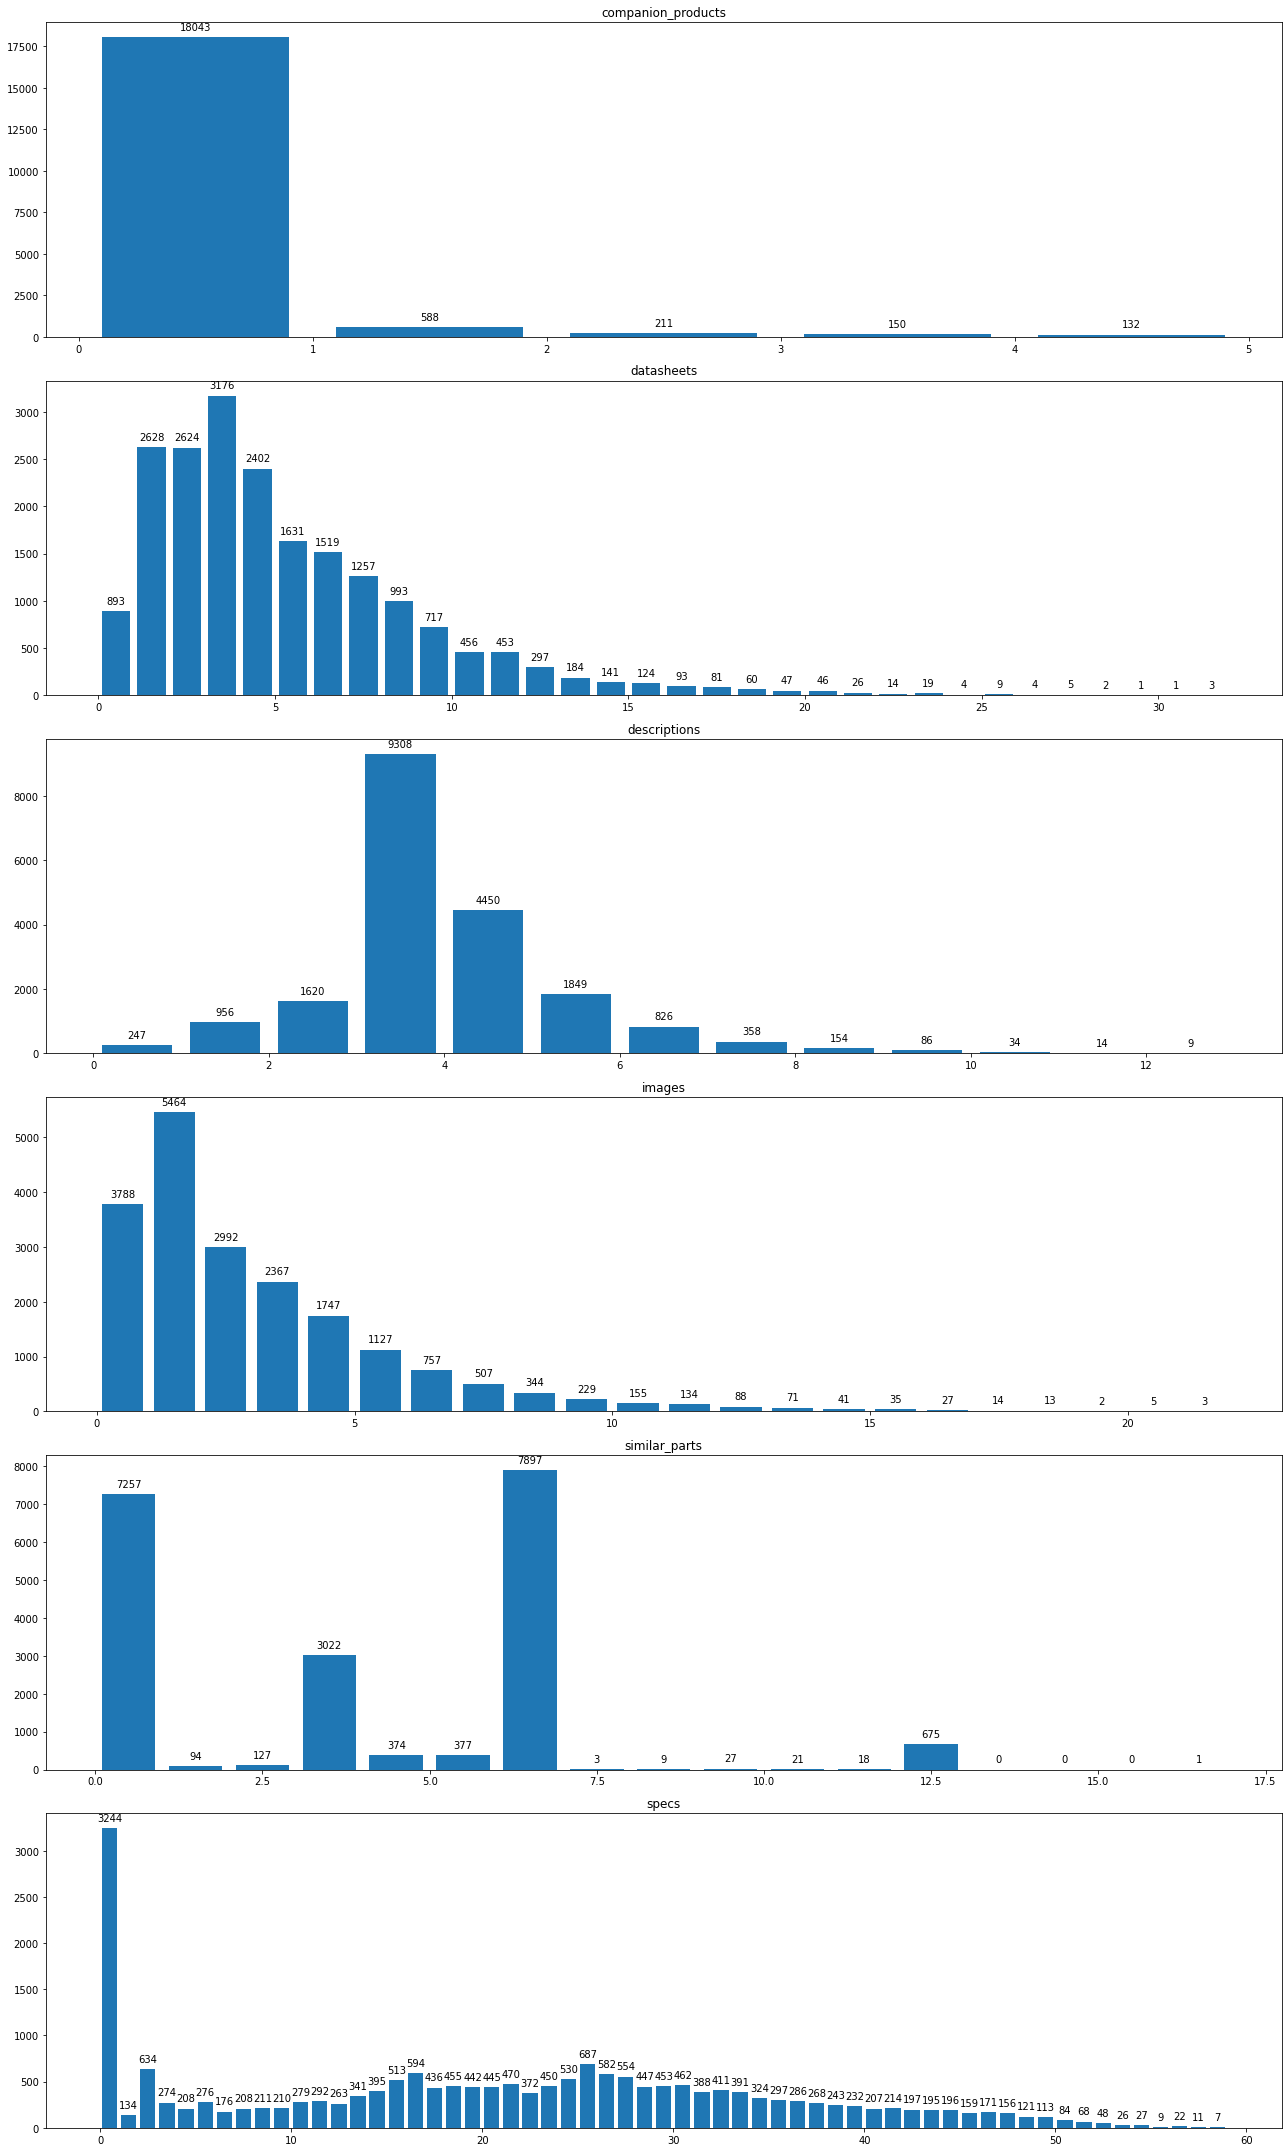

In [332]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6,1, figsize=(18,30))
for n, ax in enumerate(axes.flatten()):
    key = list(counts.keys())[n]
    counted = counts[key]
    ax.hist(counted, bins = range(0, max(counted), 1), rwidth = 0.8)

    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 

    ax.set_title(key, fontsize=12)
plt.tight_layout()
plt.show()

## Results:

Counts:
- 3244 parts without specified specs :/
- only 247 without descriptions, so these might be really helpful
- no reference designs for any part, very little companion parts, less than half have no similar parts

### Visualizing the specs themselves
Let's see which specs we can visualize, maybe string values will be difficult, if they are not categorical. We have quite many specs, so I won't do a visualization each, but rather draw some general pictures.

In [335]:
len(tech_specs)

426

In [400]:
# removing all specs that only one part had
for spec in list(tech_specs.keys()):
    if tech_specs[spec]["count"] == 1:
        del tech_specs[spec]

In [401]:
len(tech_specs)

397

In [466]:
# Visualizing each spec with its count
counts_for_spec = [(tech_specs[key]["count"], key) for key in tech_specs.keys()]
counts_for_spec = sorted(counts_for_spec, reverse = True)

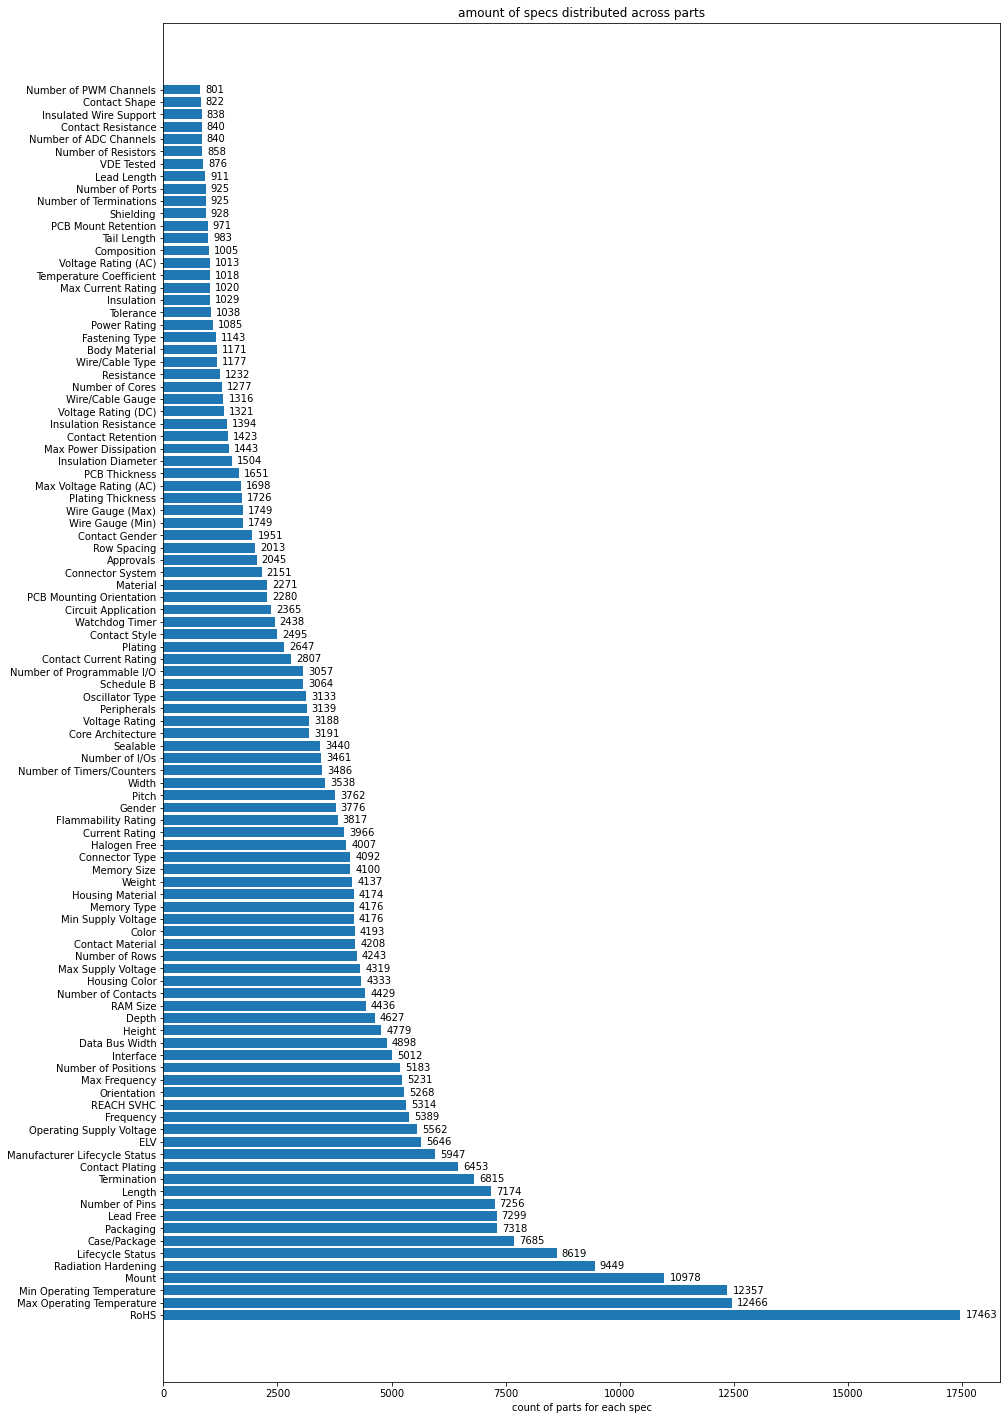

In [485]:
fig, ax = plt.subplots(1,1, figsize=(15,25))
names = [x[1] for x in counts_for_spec[:100]]
values = [x[0] for x in counts_for_spec[:100]]
ax.barh(names, values)
for rect in ax.patches:
    width = rect.get_width()
    ax.annotate(f'{int(width)}', xy=(width, rect.get_y()+rect.get_height()/2), 
                xytext=(5, 0), textcoords='offset points', ha='left', va='center')
ax.set_xlabel('count of parts for each spec', fontsize=10)
ax.set_title('amount of specs distributed across parts', fontsize=12)
# plt.tight_layout()"""
plt.show()

In [578]:
# Visualizing each count with its number of specs
spec_counts = [tech_specs[key]["count"] for key in tech_specs.keys()]
# print (sorted(spec_counts))

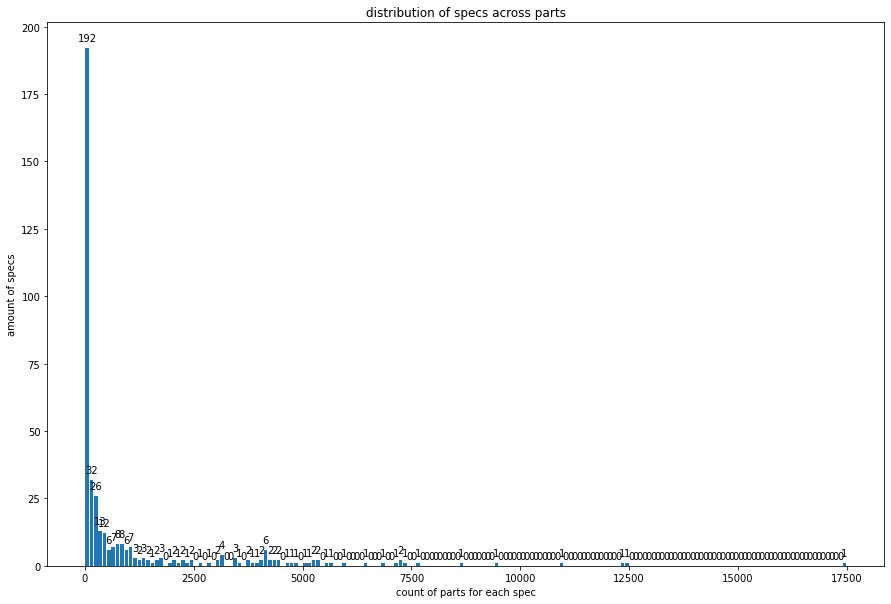

In [463]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.hist(spec_counts, bins = range(0, max(spec_counts) + 100, 100), rwidth = 0.8)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
ax.set_xlabel('count of parts for each spec', fontsize=10)
ax.set_ylabel('amount of specs', fontsize=10)
ax.set_title('distribution of specs across parts', fontsize=12)
# plt.tight_layout()
plt.show()

### First 100 specs in the specs dictionary
Integer-based:
- Number of Programmable I/O
- Number of Timers/Counters
- Number of Circuits
- Number of Contacts
- Number of Positions
- Number of Rows
- Number of Cores
- Number of Pins
- Number of ADC Channels
- Number of I2C Channels
- Number of I/Os
- Number of PWM Channels
- Number of SPI Channels
- Number of UART Channels
- Number of USB Channels
- Number of Ethernet Channels
- Number of Bits

Categorical strings:
- Case/Packaging
- Halogen Free (Halogen Free, Not Halogen Free)
- RoHS (Complaint, Non-Compliant)
- Watchdog Timer (only Yes?)
- Color (Black, Natural, Silver, Grey...), multicolors?
- Housing Color
- Housing Material
- Connector System (Wire-to-Wire, Wire-to-Board, Wire-to-Component, Cable-to-Panel...)
- Contact Gender (Male, Female)
- Contact Retention (With, Without)
- Contact Style (Pin, Socket, Straight, Shorting, Crimp...)
- ELV (Compliant, Non-Compliant)
- Fastening Type (Latch, Ramp, Friction, Pull/Push)
- Flammability Rating (UL94 V-2, UL94 V-0...)
- Gender (Male, Female, Receptacle)
- Lead Free (Not Applicable, Lead Free, Contains Lead
- Lifecycle Status (Production)
- Manufacturer Life Cycle Status (ACTIVE)
- Mount (Surface Mount, Through Hole, Free Hanging, Screw, Panel...)
- Orientation (Straight, Vertical, Right Angle ... )
- Packaging (Bulk, Tape & Reel, Cut Tape ...)
- REACH SVHC (Unknown, No SVHC, SVHC?)
- Sealable (No, Yes)
- Termination (Crimp, Through Hole, Solder...)
- VDE Tested (Yes, No)
- Mating Retention (With, Without)
- PCB Mounting Orientation (Vertical, Right Angle, Straight)
- PCB Mount Retention (With, Without)
- Plating (Gold, Tin, Silver, Nickel ...)
- Radiation Hardening (only No?)
- Wire/Cable Type (Discrete, Flat Flex, Straight...)
- Core Architecure (ARM, Coldfire, S08, RISC, PowerPC...)
- Oscillator Type (External, Internal)
- Schedule B ('8542310000', '8533210045'...)
- Shielding (No, Yes, Unshielded, Shielded)
- Contact Shape (Square, Round, Rectangular)
- High Speed Serial Data Connector (No, 2 Yes)
- High Temperature Housing (No, Yes)
- Keyed (Yes, No)
- Case Code (Imperial) ('0402', '0603', '0805' ...)

List of categorical strings:
- Interface, e.g. CAN; I2C SCI, Ethernet, UART, and so on
- Memory Type (FLASH, ROMless, ROM, SRAM), most only FLASH
- Approvals (CSA, UL, or both, VDE, IEC
- Connector Type (s)
- Contact Material (Brass, Bronze, Gold, Tin, Copper ...)
- Contact Plating (Tin, Gold, Silver, Copper, ...)
- Peripherals (LVD, POR, PWM, WDT ...)

Strings with numbers and metric measure to be converted:
- Data Bus Width (8, 16, or 32 b) (could also work as categorical)
- Max Frequency (MHz or GHz)
- Max Operating Temperature (°C)
- Min Operating Temperature (°C), minus or 0
- Memory Size (B, kB or MB, possibly GB)
- RAM Size (B, kB, MB, GB)
- Depth (mm, microm)
- Height (mm, microm)
- Length (mm, microm)
- Width: (mm, microm)
- Lifecycle Status Last Updated (5 days ago, 1 week ago ...)
- Manufacturer Lifecycle Status Last Updated
- Max Voltage Rating (AC) in V
- Max Voltage Rating (DC) in kV, V
- Operating Supply Voltage (V, evtl kV)
- Pitch (mm, microm)
- Voltage Rating (V, kV)
- Wire/Cable Gauge (AWG)
- Wire Gauge (Max) (AWG)
- Wire Gauge (Min) (AWG)
- Contact Current Rating (A, mA)
- Contact Finish Thickness - Mating (microm, nm)
- Contact Mating Length (mm)
- Contact Resistance (mOhm, MOhm, nur Ohm?)
- Current Rating (A, mA)
- Insulation Resistance (GOhm, MOHm)
- PCB Thickness (mm, microm)
- Row Spacing (mm, microm)
- Frequency (MHz, GHz)
- Max Supply Voltage (V)
- Min Supply Voltage (mV, V, can be negative)
- Weight (mg, g, microg)
- Access Time (micros)
- Max I/O Voltage (V)
- Insulation Diameter (mm, microm)
- Voltage Rating (AC) (V, kV)
- Density (Mb, kb)
- Lead Length (mm, microm)
- Mating Post Length (mm)

In [512]:
n = 21
print(list(tech_specs.keys())[n])
print(tech_specs[list(tech_specs.keys())[n]])


Depth
{'group': 'Dimensions', 'values': ['23.88 mm', '6.68 mm', '2.03 mm', '2.34 mm', '2.34 mm', '500 µm', '500 µm', '11.1 mm', '9.3 mm', '3.7 mm', '32.5 mm', '7.11 mm', '13.7 mm', '7.62 mm', '8.2 mm', '6.68 mm', '7.62 mm', '27.81 mm', '800 µm', '6.35 mm', '4.83 mm', '6.09 mm', '7.62 mm', '33.02 mm', '7 mm', '20.2 mm', '800 µm', '10.1 mm', '23.1 mm', '800 µm', '500 µm', '11.55 mm', '800 µm', '3.56 mm', '500 µm', '5.03 mm', '6.15 mm', '27.69 mm', '2.95 mm', '23.7 mm', '16.89 mm', '8.96 mm', '500 µm', '800 µm', '53.95 mm', '9.02 mm', '24 mm', '1.25 mm', '3.56 mm', '6.86 mm', '6.35 mm', '6.66 mm', '18.72 mm', '800 µm', '23.43 mm', '13.49 mm', '18.16 mm', '19.3 mm', '500 µm', '500 µm', '8 mm', '5 mm', '14.2 mm', '5.4 mm', '5.54 mm', '14.73 mm', '4.44 mm', '800 µm', '1.25 mm', '3.4 mm', '6.6 mm', '18.1 mm', '7.05 mm', '7.37 mm', '7.92 mm', '5.58 mm', '15.1 mm', '22.99 mm', '2.34 mm', '6.54 mm', '6 mm', '9.53 mm', '7.14 mm', '13.5 mm', '7.05 mm', '14.5 mm', '7.54 mm', '5.71 mm', '11.91 mm', 

In [4]:
# print(tech_specs["Mount"])

## Results:

Tech Specs:
- 426 specs, 29 with only one part (now deleted)
- A lot of specs only given for a small amount of parts
- Attributes relating to materials (Contact Plating, Contact Material and Plating
- Some irrelevent attributes may be color, housing color, and probably some others, but you would need domain knowledge for this

### Four types of attributes:
- Integer-based: Number of ...
- Categorical: often two or three categories, sometimes more or many
- List of categories: often single values, but multiple categories can apply
- With metric units: different levels of units (milli, micro, kilo, mega and so on), different units (meters, Volts, Amperes, Bytes, Hertz), also different units in different categories (technical), but dimensions is usually in meters

## Problems/Questions:
- How to handle NAs? Many attributes are only given for a small number of parts
- Handling metric units: splitting at white space, converting units into base form (without kilo or mega), multiplying number value with respective conversion factor
- Which attributes to use how? Which attributes not to use? What threshold?
    - Categorical as one-hot-encoded? Could also encode NA as additional column
    - Categorical with list as multi-hot-encoded
    - Numerical integerbased: normal, all NA as zero
    - Numerical with metric units: remove unit, convert into normal numbers, NA as zero? -> difficult
- What about "Unknown" strings in categorical attributes?
- Can this be automated? Determining which attribute is what type and removing metric units if necessary?
- If used for machine Learning, should numbers be normalized? Otherwise Frequences of MHz and GHz might influence results more than tiny differences in nm spectrum

In [567]:
tech_specs["Case/Package"]["values"]

['LQFP',
 'MAPBGA',
 'PQFP',
 'LQFP',
 'LQFP',
 'PQFP',
 'MAPBGA',
 'LQFP',
 'MAPBGA',
 'LQFP',
 '0402',
 'SIP',
 'SOIC',
 '0402',
 'SOIC',
 'SOIC W',
 'TO-272-4',
 'FCBGA',
 'MAPBGA',
 'TO-270-16',
 'MAPBGA',
 'QFN',
 '100',
 'LQFP',
 'PDIP',
 'QFP',
 'MAPBGA',
 'QFN',
 'LQFP',
 'LQFP',
 'TSSOP',
 'SMD/SMT',
 'LQFP',
 '0603',
 'FCBGA',
 'LQFP',
 'Conformal',
 'SOIC',
 'TO-270-2',
 'FCBGA',
 '0603',
 'SOIC W',
 'PDIP',
 '120',
 '125',
 '0805',
 'LQFP',
 'SOP',
 'QFN',
 'LQFP',
 '0603',
 'SOIC W',
 'Metal',
 '0603',
 'SMA',
 'LQFP',
 '0402',
 'TFBGA',
 'FCBGA',
 'BGA',
 '0603',
 'FBGA',
 'FBGA',
 'PQFP',
 '0402',
 'QFN',
 'LQFP',
 'TO-270',
 '1206',
 'TSSOP',
 'LQFP',
 '0402',
 '0603',
 'LQFP',
 'MAPBGA',
 'BGA',
 '0805',
 'TO-270',
 'BGA',
 'Conformal',
 'QFP',
 'LQFP',
 'TSSOP',
 'PQFP',
 'Conformal',
 '0603',
 'MAPBGA',
 'LQFP',
 'SOIC',
 'LQFP',
 'LQFP',
 '0402',
 'BGA',
 'LQFP',
 '0402',
 'Axial',
 'QFP',
 'TSSOP',
 'LQFP',
 'LQFP',
 'BGA',
 'LQFP',
 'BGA',
 'LQFP',
 'QFN',
 'TSSOP

## A script for removing metric units and scaling the number value accordingly

Let's prepare a script that will turn strings with units into integers/floats, cause we will need it anyway:

In [557]:
from typing import List, Tuple, Set, Dict
from decimal import *
getcontext().prec = 10

modifier_to_factor = {"p": 1/10**12,
            "n": Decimal(1)/Decimal(10**9),
            "µ": Decimal(1)/Decimal(10**6),
            "m": Decimal(1)/Decimal(10**3),
            "": 1,
            "k": 10**3,
            "M": 10**6,
            "G": 10**9,
            "T": 10**12}

units = set(["m", "Hz", "V", "A", "b", "B", "Ω", "s", "°C", "AWG", "g"])

def convert_metrics(data: List[str]) -> Tuple[List[Decimal], str]:
    results = []
    base_metric = ""
    for info in data:
        number, metric = info.split(" ")
        number = Decimal(number)
        if metric in units:
            if metric != base_metric:
                if base_metric != "":
                    print("Changing base metric from", base_metric, "to", "metric")
                base_metric = metric
        elif len(metric) > 1 and metric[0] in modifier_to_factor and metric[1:] in units:
            modifier = metric[0]
            factor = modifier_to_factor[modifier]
            number *= factor
            
        else:
            print("Unknown metric or modifier in", info)
            
            
        if int(number) == float(number):
            results.append(int(number))
        else:
            results.append(float(number))
        
    return (results, base_metric)

In [564]:
keys_of_to_convert = ["Data Bus Width", "Max Frequency", "Max Operating Temperature", "Min Operating Temperature", 
                      "Memory Size", "RAM Size", "Depth", "Height", "Length", "Width", "Max Voltage Rating (AC)", 
                      "Max Voltage Rating (DC)", "Operating Supply Voltage", "Pitch", "Voltage Rating", 
                      "Wire/Cable Gauge", "Wire Gauge (Max)", "Wire Gauge (Min)", "Contact Current Rating", 
                      "Contact Finish Thickness - Mating", "Contact Mating Length", "Contact Resistance", "Current Rating",
                      "Insulation Resistance", "PCB Thickness", "Row Spacing", "Frequency", "Max Supply Voltage", 
                      "Min Supply Voltage", "Weight", "Access Time", "Max I/O Voltage", "Insulation Diameter", 
                      "Voltage Rating (AC)", "Density", "Lead Length", "Mating Post Length"]

In [565]:
for key in keys_of_to_convert:
    convert_metrics(tech_specs[key]["values"])

No error messages, seems to have worked. Can therefor be used for these attributes to convert measures.